## Comparative analysis for the baseline fitting of denatured and folded protein

In [ ]:
#imports for the plotting of pychemelt

import plotly.graph_objs as go
import matplotlib.pyplot as plt

from pychemelt.utils.plotting import plot_unfolding
from pychemelt import Sample
from pychemelt.utils.processing import estimate_signal_baseline_params

import numpy as np
import pandas as pd


def model(x, a, b, c=None, kind=None):
    """
    Encoding functions for baseline fitting
    """
    if kind == "linear":
        return a + x * b
    elif kind == "quadratic":
        return a + b*x + c*(x**2)
    elif kind == "exponential":
        return a + b * np.exp(-c * x)
    else:
        raise ValueError("Unknown model type")
    

def rmse(x1, x2):
    """
    Implementation of RMSE
    """
    return np.sqrt(np.mean((x1 - x2)**2))

Native baseline function parameters:
[[np.float64(96.77370571283522), np.float64(92.02976110512243), np.float64(97.70790359744777), np.float64(100.36789534500497)]]
[[np.float64(-1.78646422456422), np.float64(-1.6084991545066096), np.float64(-1.703397534406661), np.float64(-1.7459611336961816)]]
[[np.float64(0.016183217125433587), np.float64(0.014207775564901912), np.float64(0.015135240629290071), np.float64(0.01491953747093007)]]
quadratic
Unfolded baseline function parameters:
[[np.float64(87.55275296945818), np.float64(79.1024594969157), np.float64(84.1580513735599), np.float64(90.03873108981334)]]
[[np.float64(-1.1015957343550042), np.float64(-0.9521183655351408), np.float64(-1.0173641249572105), np.float64(-1.1640071696278467)]]
[[np.float64(0.0035462189599863537), np.float64(0.0038166195105376424), np.float64(0.004104504786520737), np.float64(0.0051412158181446425)]]
quadratic


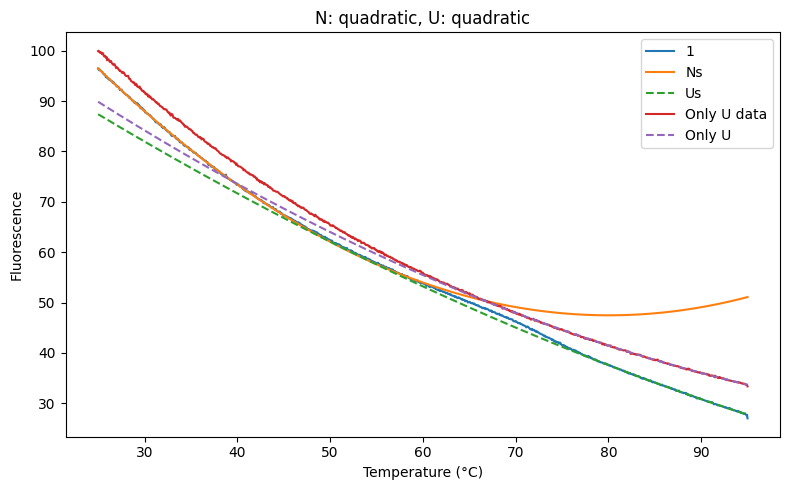

Native baseline function parameters:
[[np.float64(7.982965738626842), np.float64(10.54482586557818), np.float64(11.907723207979883), np.float64(8.512887742072788)]]
[[np.float64(88.79759927575084), np.float64(81.49463448643644), np.float64(85.81065431290787), np.float64(91.86441327520134)]]
[[np.float64(0.020212336124973678), np.float64(0.019848904727398416), np.float64(0.01996227859657849), np.float64(0.019102776515059337)]]
exponential
Unfolded baseline function parameters:
[[np.float64(3.909400997383023e-10), np.float64(5.497024962964038), np.float64(6.580329305097182), np.float64(11.964541217746302)]]
[[np.float64(117.21136327334865), np.float64(80.66177256902775), np.float64(85.7295127721306), np.float64(91.52315304222542)]]
[[np.float64(0.02051135431157871), np.float64(0.01636396894700492), np.float64(0.016786757579355466), np.float64(0.020506129874793128)]]
exponential


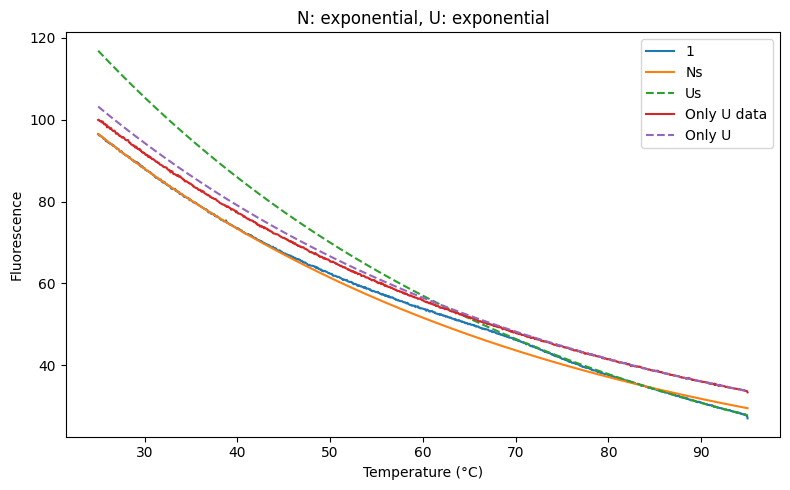

Native baseline function parameters:
[[np.float64(96.77370571283522), np.float64(92.02976110512243), np.float64(97.70790359744777), np.float64(100.36789534500497)]]
[[np.float64(-1.78646422456422), np.float64(-1.6084991545066096), np.float64(-1.703397534406661), np.float64(-1.7459611336961816)]]
[[np.float64(0.016183217125433587), np.float64(0.014207775564901912), np.float64(0.015135240629290071), np.float64(0.01491953747093007)]]
quadratic
Unfolded baseline function parameters:
[[np.float64(3.909400997383023e-10), np.float64(5.497024962964038), np.float64(6.580329305097182), np.float64(11.964541217746302)]]
[[np.float64(117.21136327334865), np.float64(80.66177256902775), np.float64(85.7295127721306), np.float64(91.52315304222542)]]
[[np.float64(0.02051135431157871), np.float64(0.01636396894700492), np.float64(0.016786757579355466), np.float64(0.020506129874793128)]]
exponential


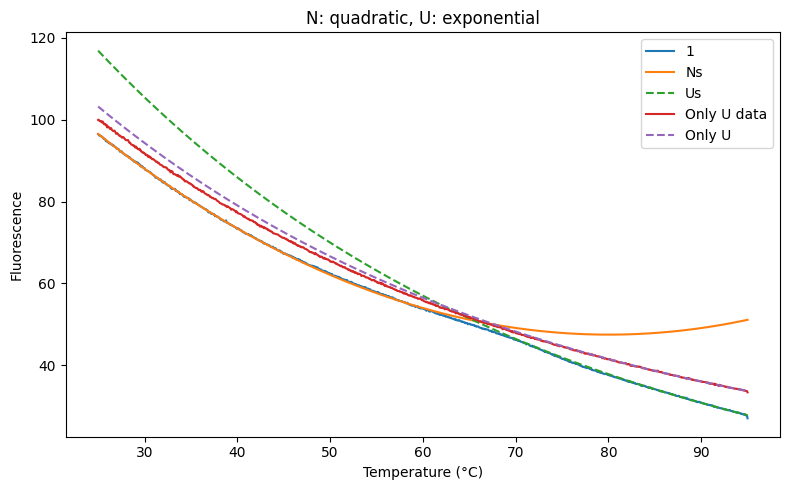

In [ ]:


def evaluate_single(native_bl, unfolded_bl, signal): 

    #using pychemelts sample structure for the loading of the data and prediction

    sample = Sample()

    sample.read_multiple_files('../data/nDSFdemoFile.xlsx')
    sample.set_denaturant_concentrations()

    #currently only one signal present
    sample.set_signal([signal])

    #one curve as a test
    #sample.select_conditions([True] + [False for _ in range(47)])    #test curve 1
    
    sample.select_conditions([True] + [False for _ in range(17)] + [True for _ in range(18, 21)] + [False for _ in range(48 - 21)])    #samples with no guessed inflection w\o M6.54


    #fit the baselines based on the given 
    sample.estimate_baseline_parameters(
        native_baseline_type=native_bl,
        unfolded_baseline_type=unfolded_bl,
    )

    # assign the parameters to 
    a_n = sample.first_param_Ns_per_signal[0][0]
    b_n = sample.second_param_Ns_per_signal[0][0]
    c_n = sample.third_param_Ns_per_signal[0][0]

    a_u = sample.first_param_Us_per_signal[0][0]
    b_u = sample.second_param_Us_per_signal[0][0]
    c_u = sample.third_param_Us_per_signal[0][0]


    #assigning preprocessed signal and temperature for plotting
    temperature = sample.temp_lst_multiple[0][0]     
    fluorescence = sample.signal_lst_multiple[0][0]       

    #using the removed reference temperature for plotting
    temperature_K = temperature + 273.15
    temperature_K_ref = temperature_K - 298

    y_ns = model(temperature_K_ref,
                a_n,
                b_n,
                c_n,
                kind=sample.native_baseline_type)

    y_us = model(temperature_K_ref,
                a_u,
                b_u,
                c_u,
                kind=sample.unfolded_baseline_type)


    y_ou = model(temperature_K_ref,
                sample.first_param_Us_per_signal[0][-1],
                sample.second_param_Us_per_signal[0][-1],
                sample.third_param_Us_per_signal[0][-1],
                kind=sample.unfolded_baseline_type)


    # plotting
    plt.figure(figsize=(8, 5))


    plt.plot(temperature, fluorescence, label="1")

    plt.plot(temperature, y_us, label="Us", linestyle="--")
    plt.plot(temperature, sample.signal_lst_multiple[0][-1], label="Only U data")
    plt.plot(temperature, y_ou, label="Only U", linestyle="--")

    plt.xlabel("Temperature (°C)")
    plt.ylabel("Fluorescence")
    plt.title("N: "+ native_bl + ", U: " + unfolded_bl)
    plt.legend()
    plt.tight_layout()
    plt.show()


signal = "330nm"

evaluate_single("quadratic", "quadratic", signal)

evaluate_single("exponential", "exponential", signal)

evaluate_single("quadratic", "exponential", signal)



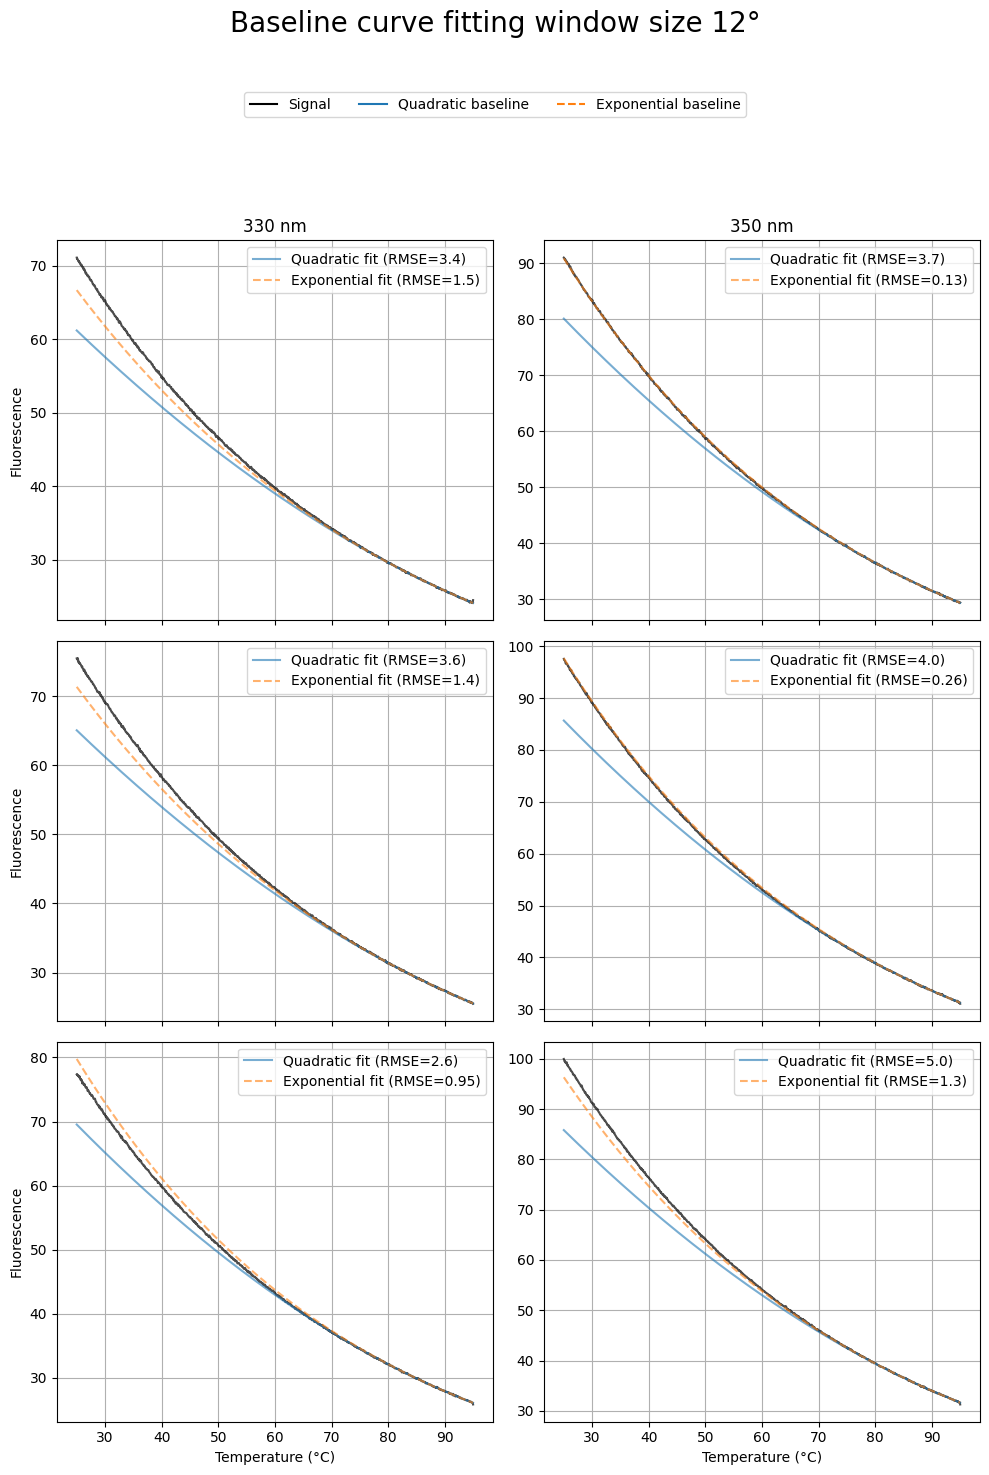

[[[np.float64(3.4396446796990525), np.float64(1.535566939051075)],
  [np.float64(3.621256500828086), np.float64(1.432078270378666)],
  [np.float64(2.616991092977953), np.float64(0.9510385903527974)]],
 [[np.float64(3.711511117543057), np.float64(0.12737841176922188)],
  [np.float64(3.989031643563574), np.float64(0.2595210760127971)],
  [np.float64(4.961612095595462), np.float64(1.325137155384377)]]]

In [ ]:


def unfolded_comp(conditions, filename="../data/nDSFdemoFile.xlsx", ws=12): 
    """
    Compare quadratic and exponential unfolded baseline fits for DSF data with unfolded curves.

    This function loads DSF fluorescence data using the pychemelts `Sample`
    interface, estimates unfolded-state baselines using both quadratic and
    exponential models, compares their performance using RMSE, and visualizes
    the results for two fluorescence signals (330 nm and 350 nm).

    Parameters
    ----------
    conditions : list of bool
        Boolean mask specifying which experimental conditions are selected
        for analysis. Length must match the number of experiments in the input
        dataset. Typically, `True` values correspond to curves without an
        inflection point used for unfolded baseline estimation.

    ws : int, optional, Default 12
        Window size (in °C) used for fitting the unfolded baseline.
        This parameter defines the temperature range over which the baseline
        parameters are estimated. Default is 12.

    Returns
    -------
    rmses: list
        The RMSE values of both baselines for all curves for both wavelengths.

    Notes
    -----
    - RMSE is computed between the measured fluorescence signal and the fitted
      baseline for each denaturant concentration and signal.
    - Temperatures are internally converted to Kelvin and referenced to 298 K
      before model evaluation.
    - A shared legend and figure-level title are used for visualization.

    Examples
    --------
    >>> conditions = (
    ...     [False] * 18
    ...     + [True] * 3
    ...     + [False] * (48 - 21)
    ... )
    >>> unfolded_comp(conditions, ws=12)
    """
        
    #using pychemelts sample structure for the loading of the data and prediction

    sample = Sample()
    sample.read_multiple_files(filename)
    sample.set_denaturant_concentrations()

    #usage of 330nm and 350nm for the initial curves
    sample.set_signal(["330nm", "350nm"])
    
    #experiments used for evaluation, should be curves without inflection 
    sample.select_conditions(conditions)    


    #fit the baselines as quadratic curve
    sample.estimate_baseline_parameters(
        native_baseline_type="linear",
        unfolded_baseline_type="quadratic",
        window_range_unfolded=ws
    )

    a_quas = sample.first_param_Us_per_signal
    b_quas = sample.second_param_Us_per_signal
    c_quas = sample.third_param_Us_per_signal

    #fit the baselines as exponential curve
    sample.estimate_baseline_parameters(
        native_baseline_type="linear",
        unfolded_baseline_type="exponential",
        window_range_unfolded=ws
    )

    a_exps = sample.first_param_Us_per_signal
    b_exps = sample.second_param_Us_per_signal
    c_exps = sample.third_param_Us_per_signal

    #assigning preprocessed signal and temperature for plotting
    temperature = sample.temp_lst_multiple[0][0]     
    fluorescences = sample.signal_lst_multiple  

    #using the removed reference temperature for plotting
    temperature_K = temperature + 273.15
    temperature_K_ref = temperature_K - 298

    #creating all formula results for comparison and plots

    fig, axes = plt.subplots(
    ncols=2,
    nrows=sample.nr_den,
    figsize=(10, 5 * sample.nr_den),
    sharex=True,
    )

    signal_labels = ["330 nm", "350 nm"]


    rmses = []

    for i in range(2):    # 330nm and 350nm

        rmses_tmp = []

        for j in range(sample.nr_den):
            
            ax = axes[j, i]

            rmses_formulas = []

            qua_bl = model(temperature_K_ref,
                a_quas[i][j],
                b_quas[i][j],
                c_quas[i][j],
                kind="quadratic")


            
            rmses_formulas.append(rmse(fluorescences[i][j], qua_bl))

            exp_bl = model(temperature_K_ref,
                a_exps[i][j],
                b_exps[i][j],
                c_exps[i][j],
                kind="exponential")

            
            rmses_formulas.append(rmse(fluorescences[i][j], exp_bl))

            rmses_tmp.append(rmses_formulas)

            #plotting the results
            ax.plot(
            temperature,
            fluorescences[i][j],
            color="black",
            alpha=0.7
            )

            ax.plot(
            temperature,
            qua_bl,
            color="tab:blue",
            alpha=0.6,
            label=f"Quadratic fit (RMSE={rmses_formulas[0]:.2})"
            )

            ax.plot(
            temperature,
            exp_bl,
            color="tab:orange",
            linestyle="--",
            alpha=0.6,
            label=f"Exponential fit (RMSE={rmses_formulas[1]:.2})"
            )


            if j == 0:
                ax.set_title(["330 nm", "350 nm"][i])

            if i == 0:
                ax.set_ylabel("Fluorescence")

            ax.legend()
            ax.grid(True)

        rmses.append(rmses_tmp)
        
        ax.set_xlabel("Temperature (°C)")



    # manual legend (once)
    handles = [
        plt.Line2D([0], [0], color="black", label="Signal"),
        plt.Line2D([0], [0], color="tab:blue", label="Quadratic baseline"),
        plt.Line2D([0], [0], color="tab:orange", linestyle="--", label="Exponential baseline"),
    ]

    fig.suptitle("Baseline curve fitting window size " + str(ws) + "°", fontsize=20)
    fig.legend(handles=handles, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.93))
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()

    return rmses


conditions = [False] * 18 + [True] * (18, 21) + [False] * (48 - 21)


unfolded_comp(conditions)





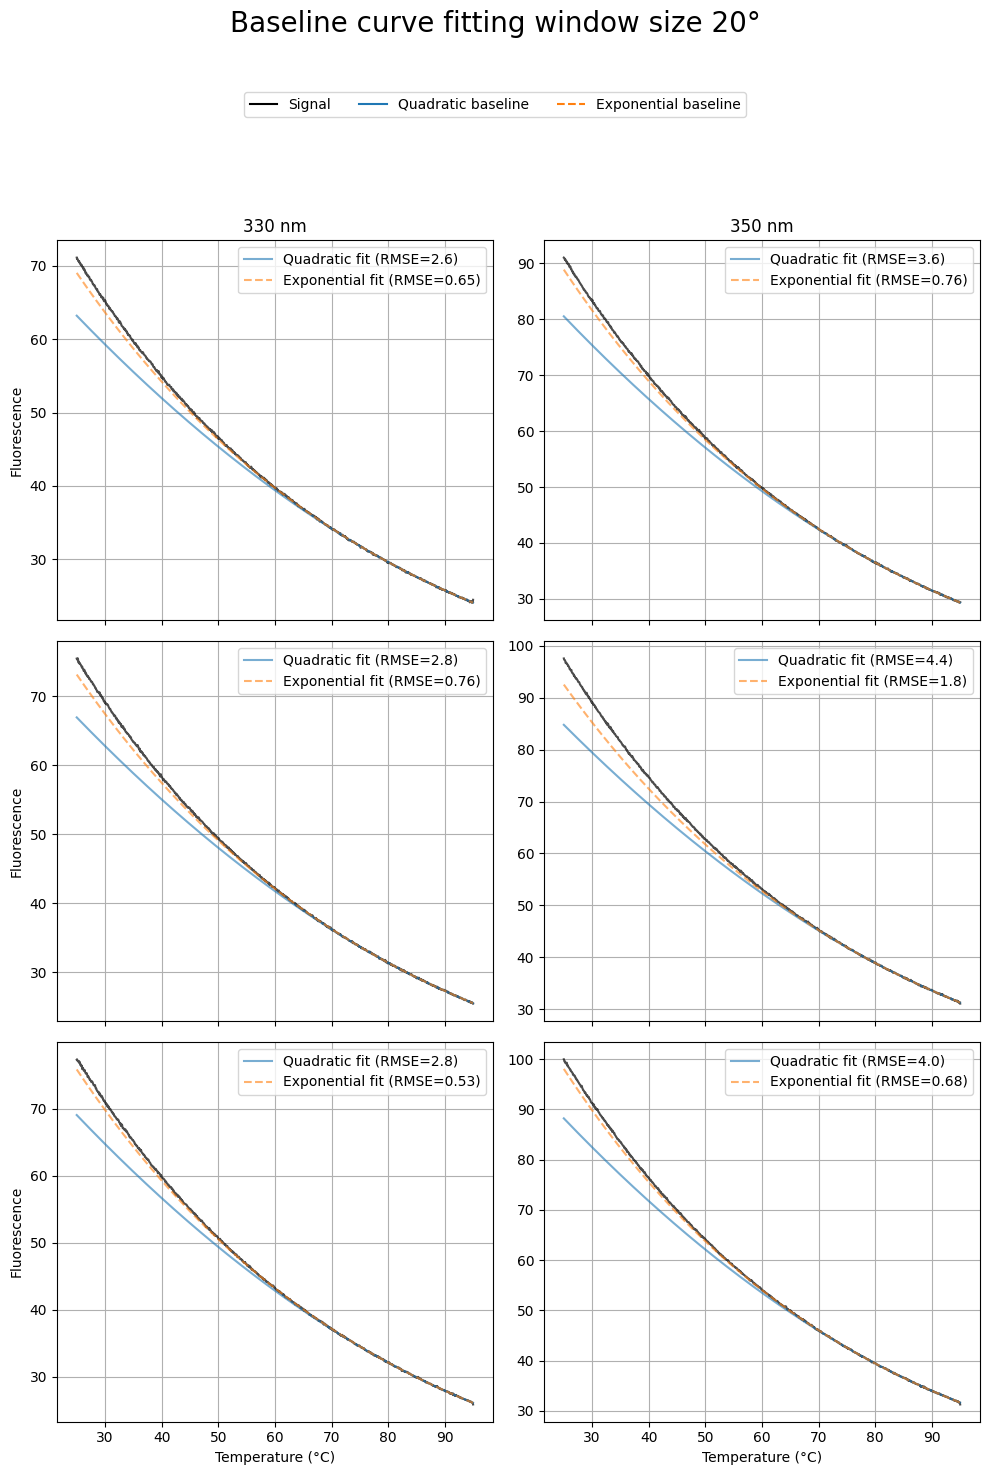

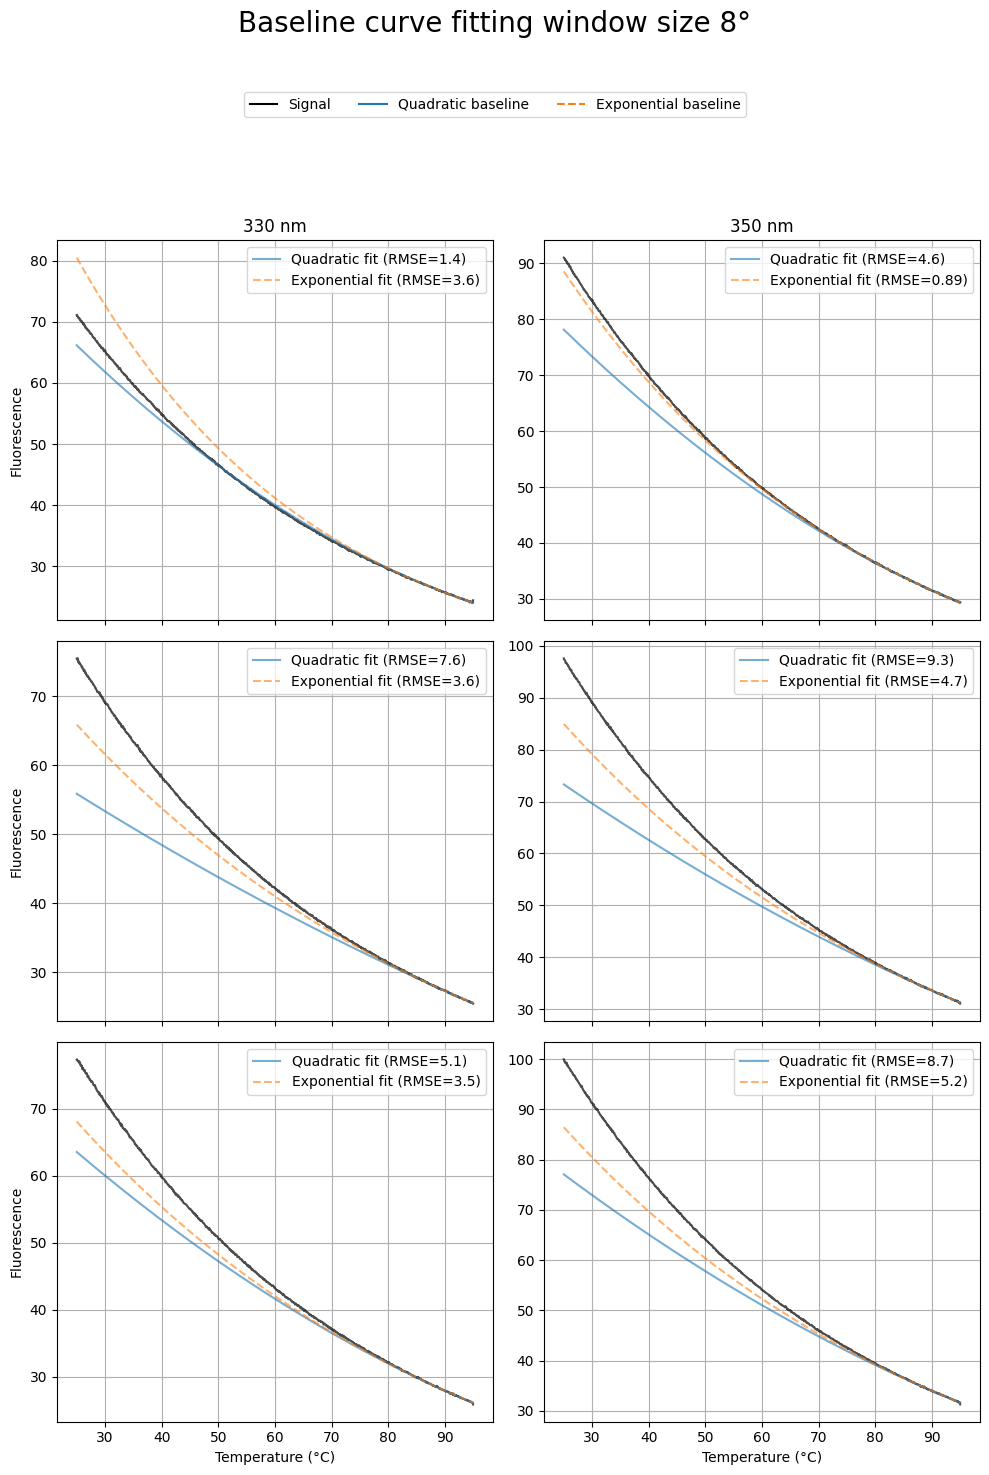

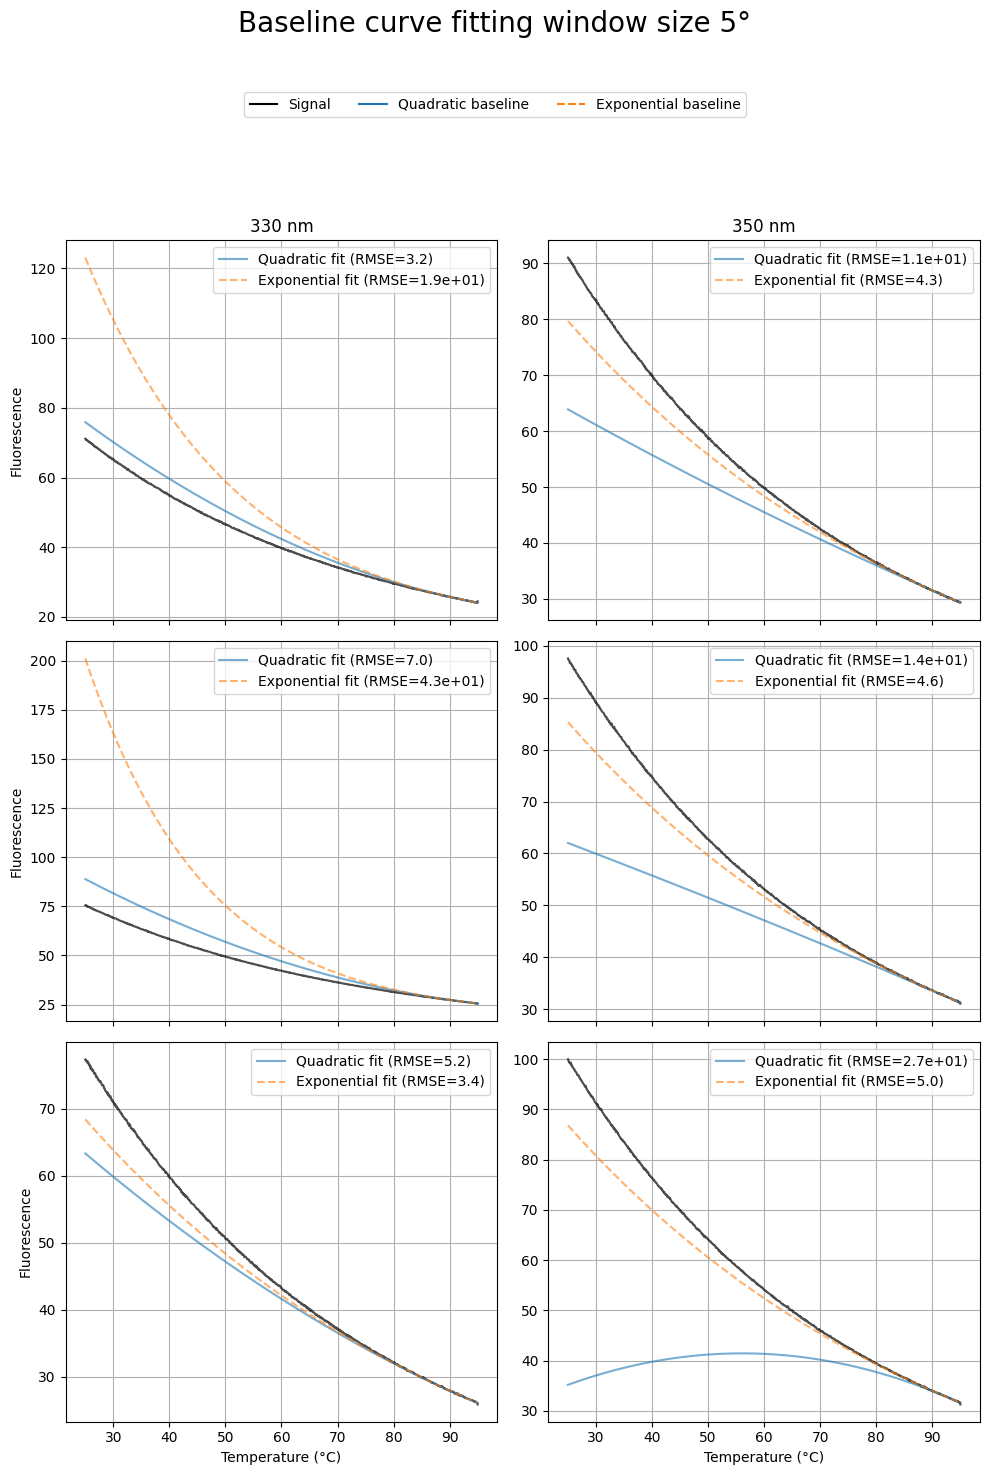

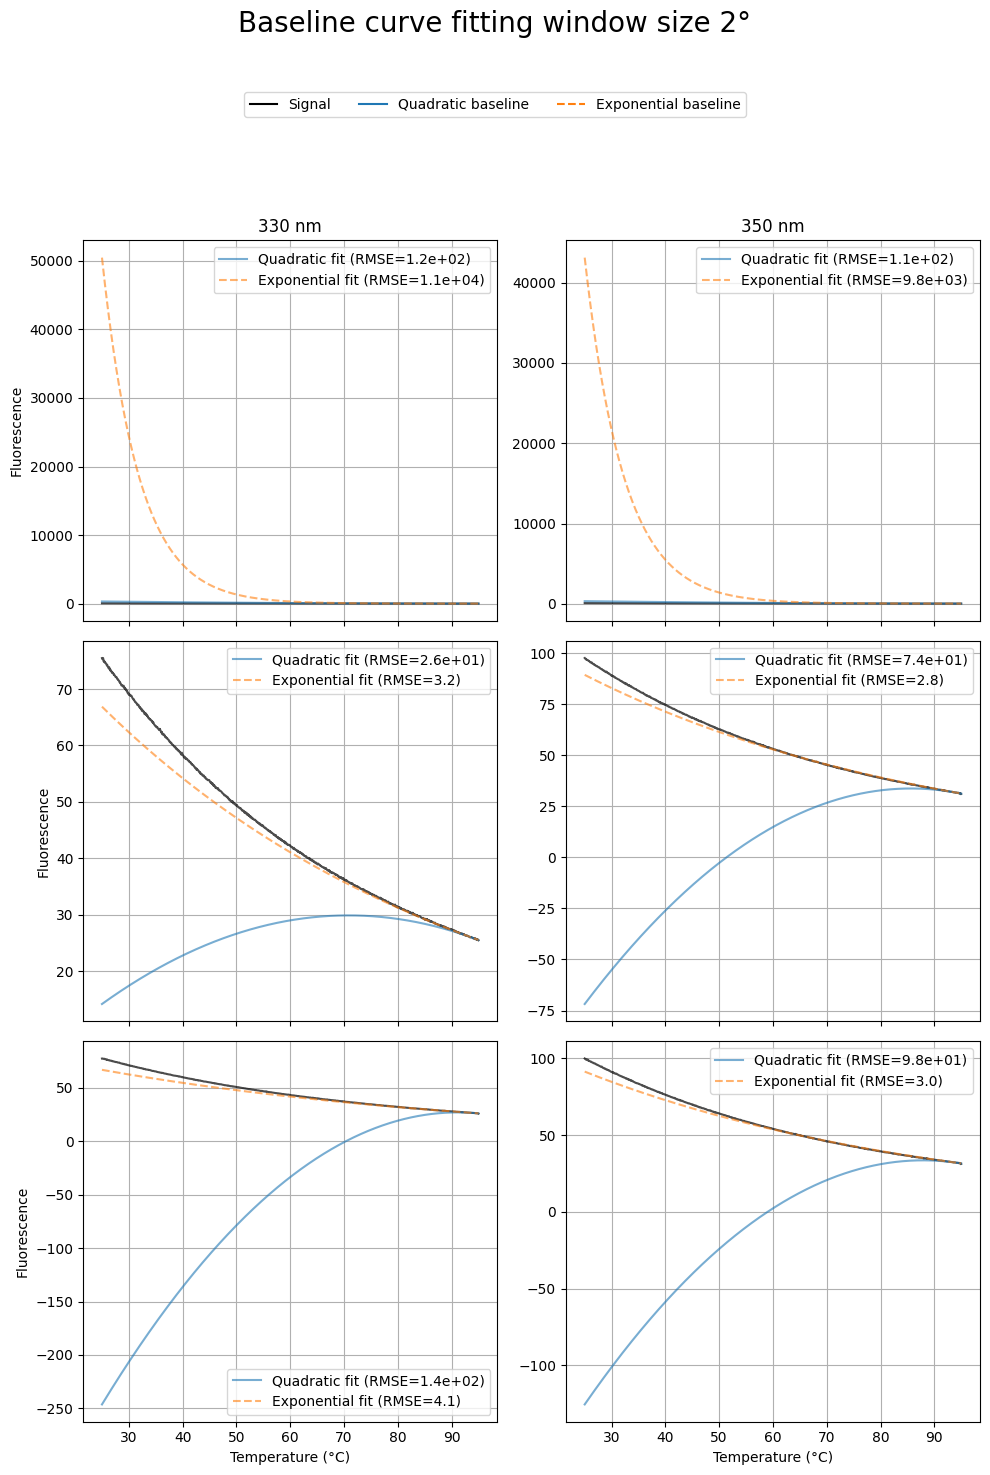

[[[np.float64(117.46165578595638), np.float64(11192.620190788059)],
  [np.float64(26.144105177916792), np.float64(3.226133035954148)],
  [np.float64(142.72485354689883), np.float64(4.098756398856747)]],
 [[np.float64(107.86680457092231), np.float64(9822.151868673574)],
  [np.float64(73.55184818653697), np.float64(2.7964911722292647)],
  [np.float64(98.49627141263406), np.float64(2.9683786479934917)]]]

In [152]:
#comparing the fits using different window sizes

unfolded_comp(conditions, ws=20)

unfolded_comp(conditions, ws=8)

unfolded_comp(conditions, ws=5)

unfolded_comp(conditions, ws=2)

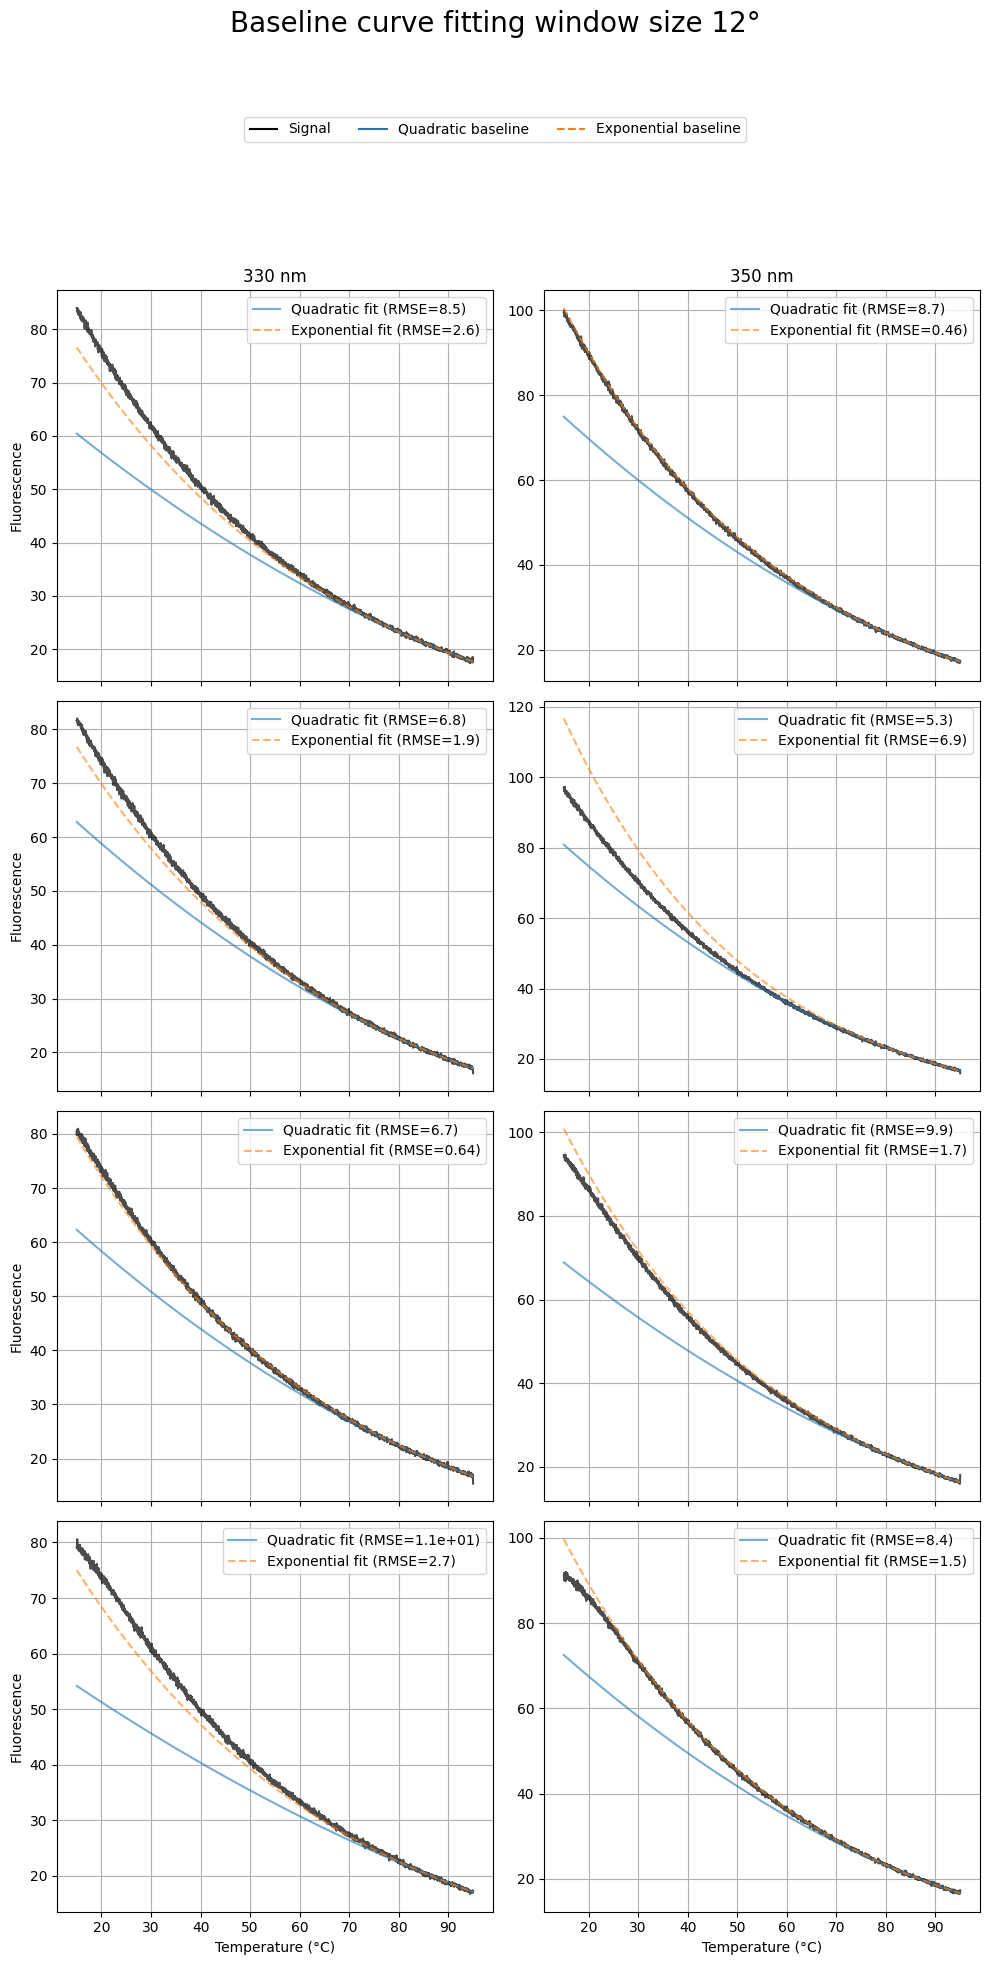

[[[np.float64(8.524497499047154), np.float64(2.6158713959412077)],
  [np.float64(6.792399805492821), np.float64(1.8790207213785772)],
  [np.float64(6.7137827981096985), np.float64(0.6374273758323568)],
  [np.float64(10.529949930471794), np.float64(2.656834208100453)]],
 [[np.float64(8.684902132898012), np.float64(0.45834735113046593)],
  [np.float64(5.283526538436798), np.float64(6.877158955894937)],
  [np.float64(9.86685978384112), np.float64(1.746258879993591)],
  [np.float64(8.410218366354002), np.float64(1.5388611876761051)]]]

In [159]:
#trying a different dataset

conditions_nf = [True] * 4 + [False] * (16 - 4)

filename = "../data/20191202_ACBP_15C_95C_processed.xlsx"

unfolded_comp(conditions_nf, filename)

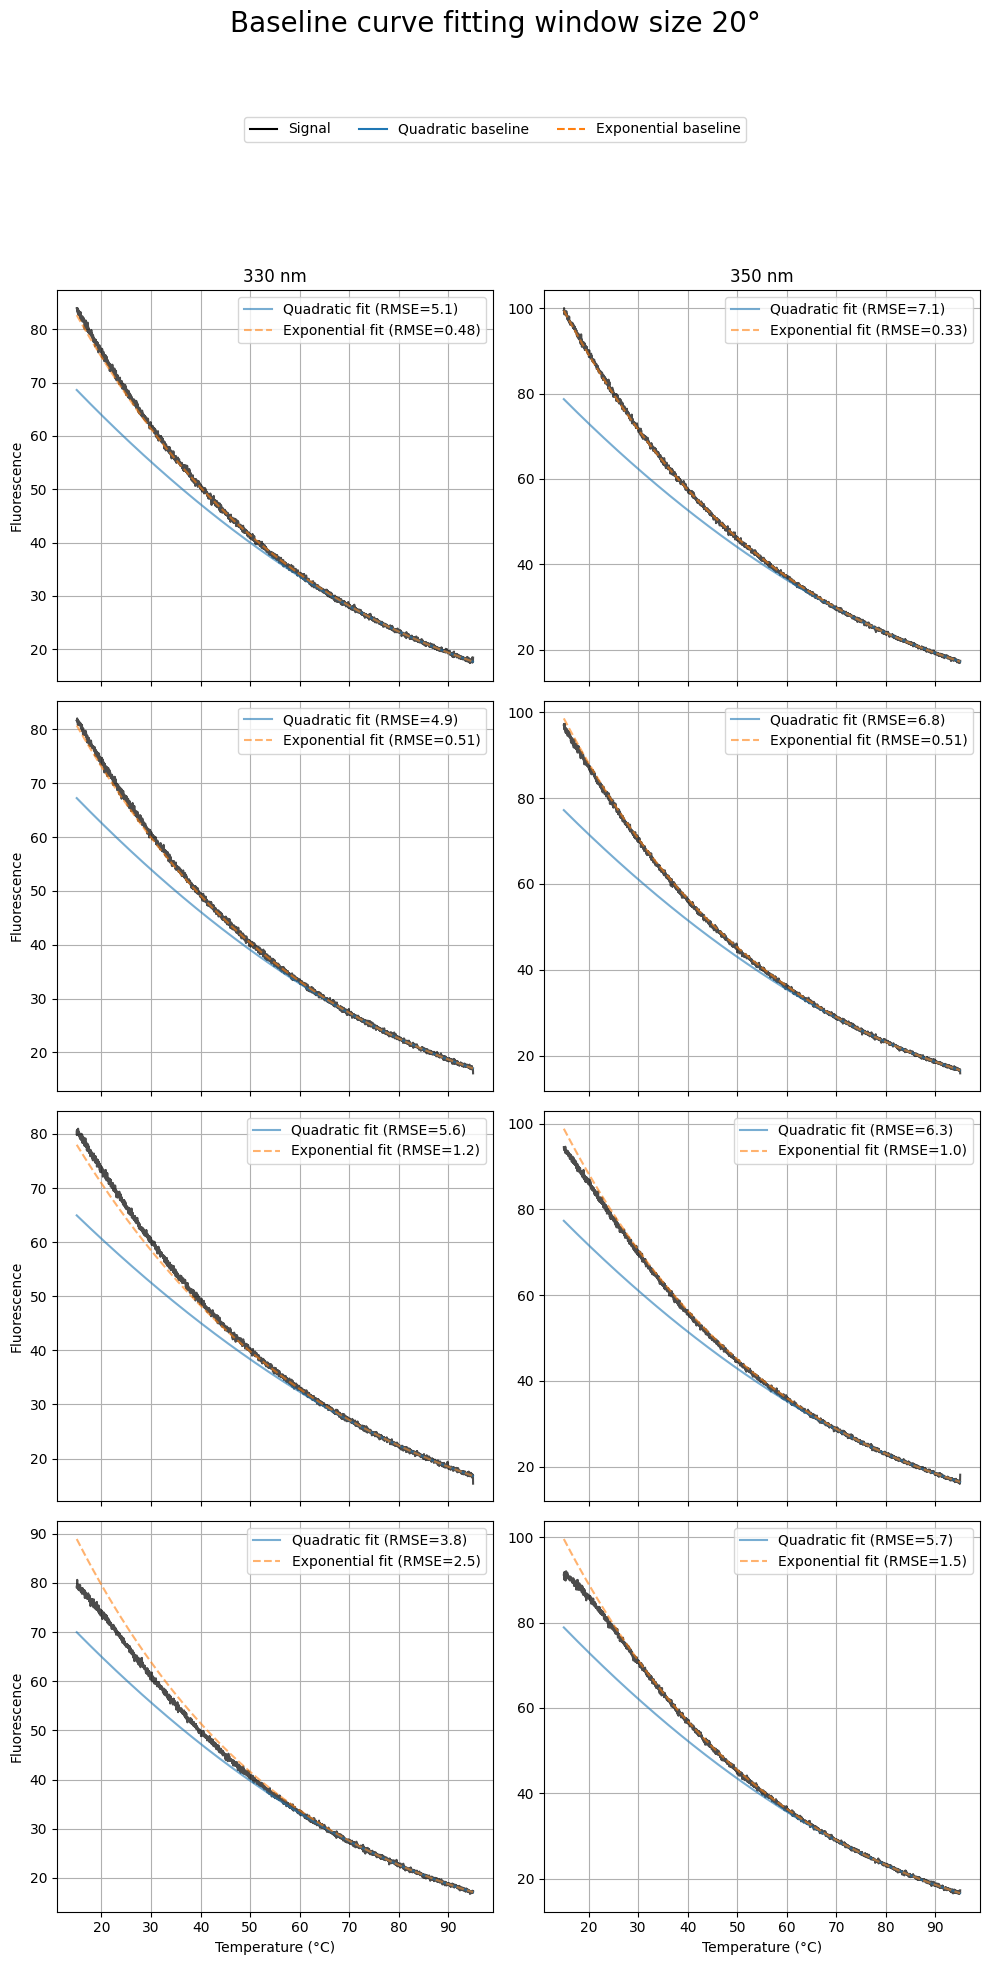

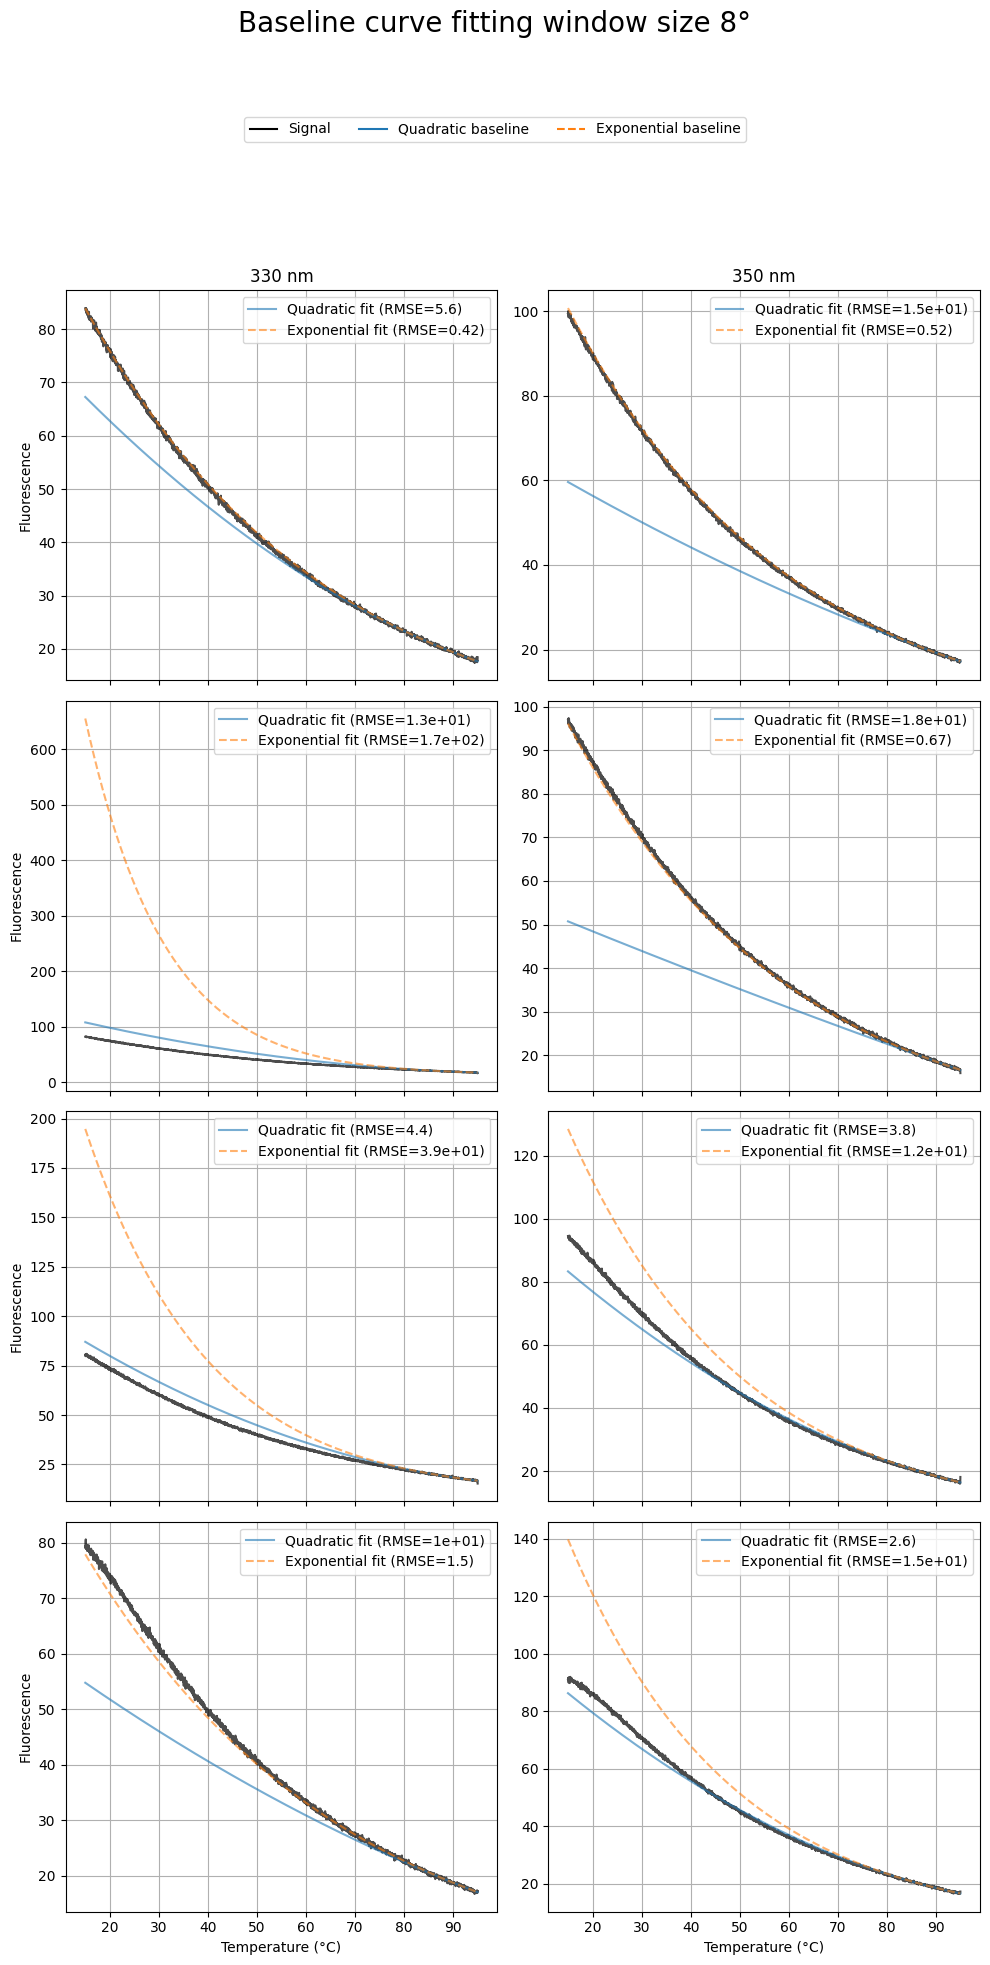

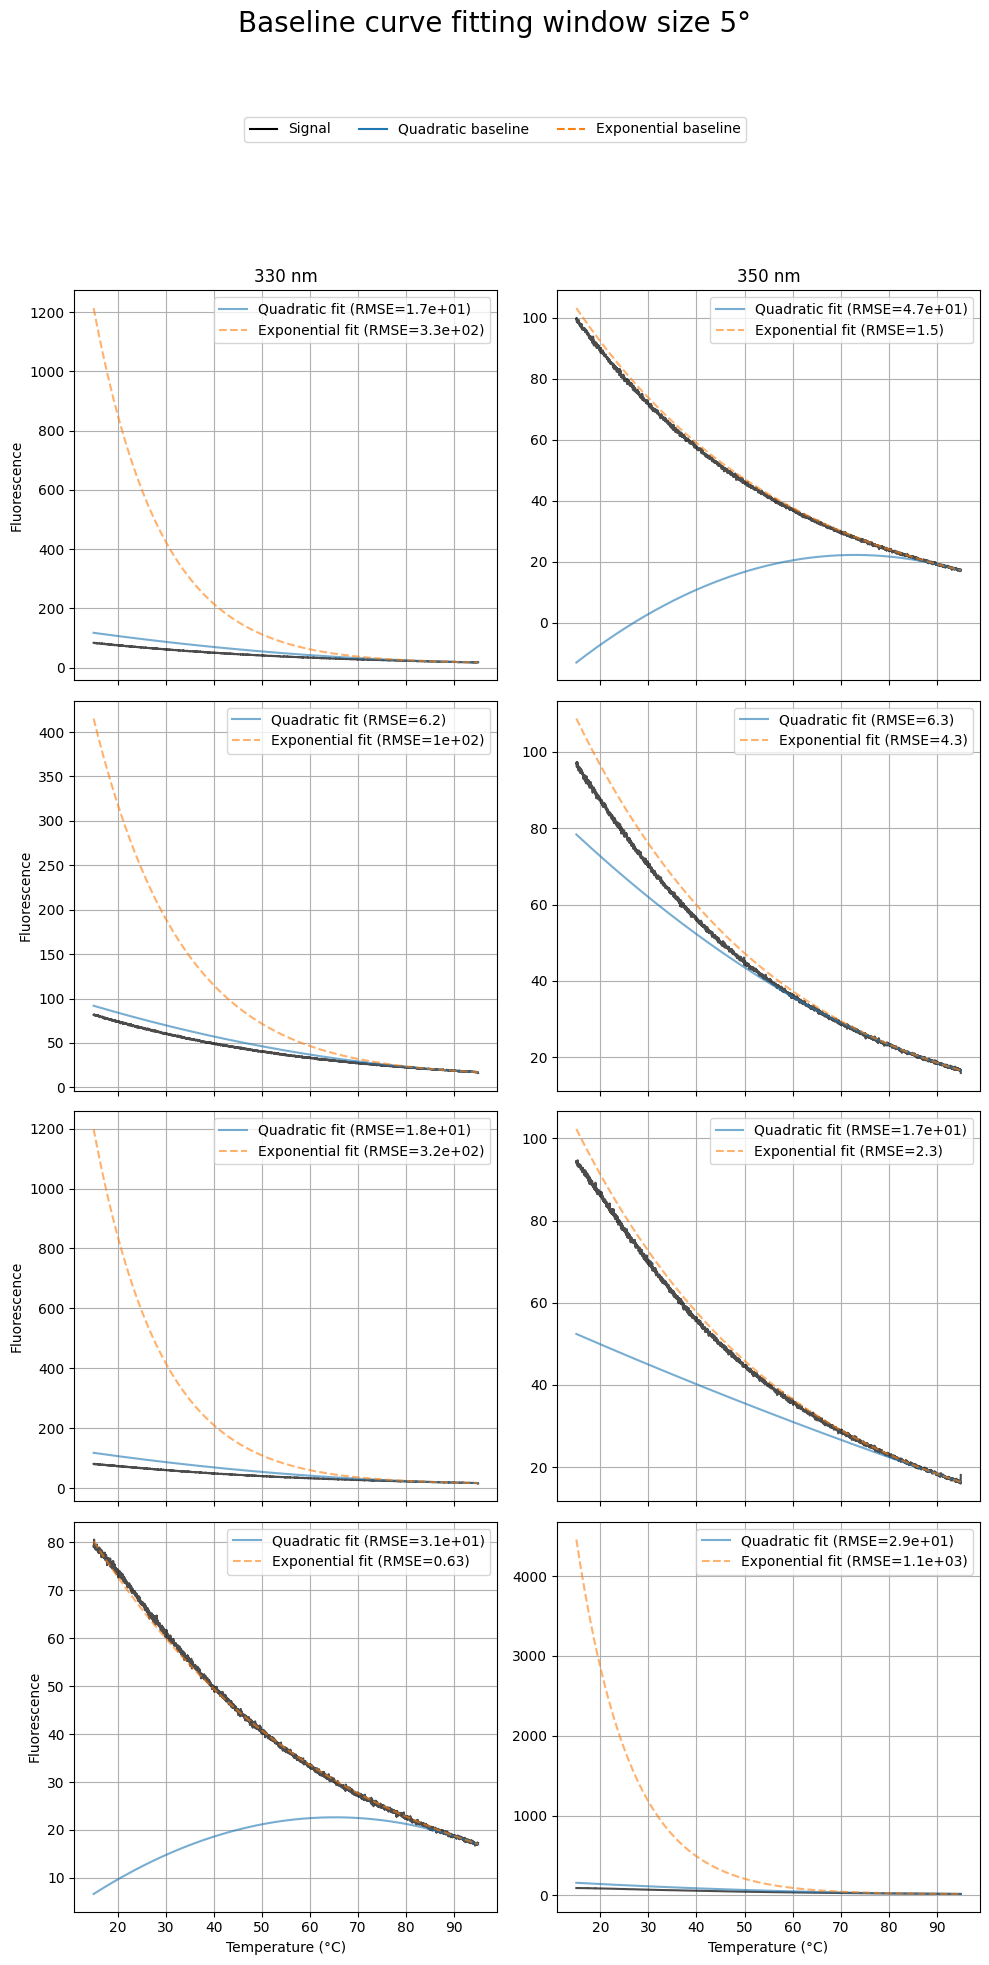

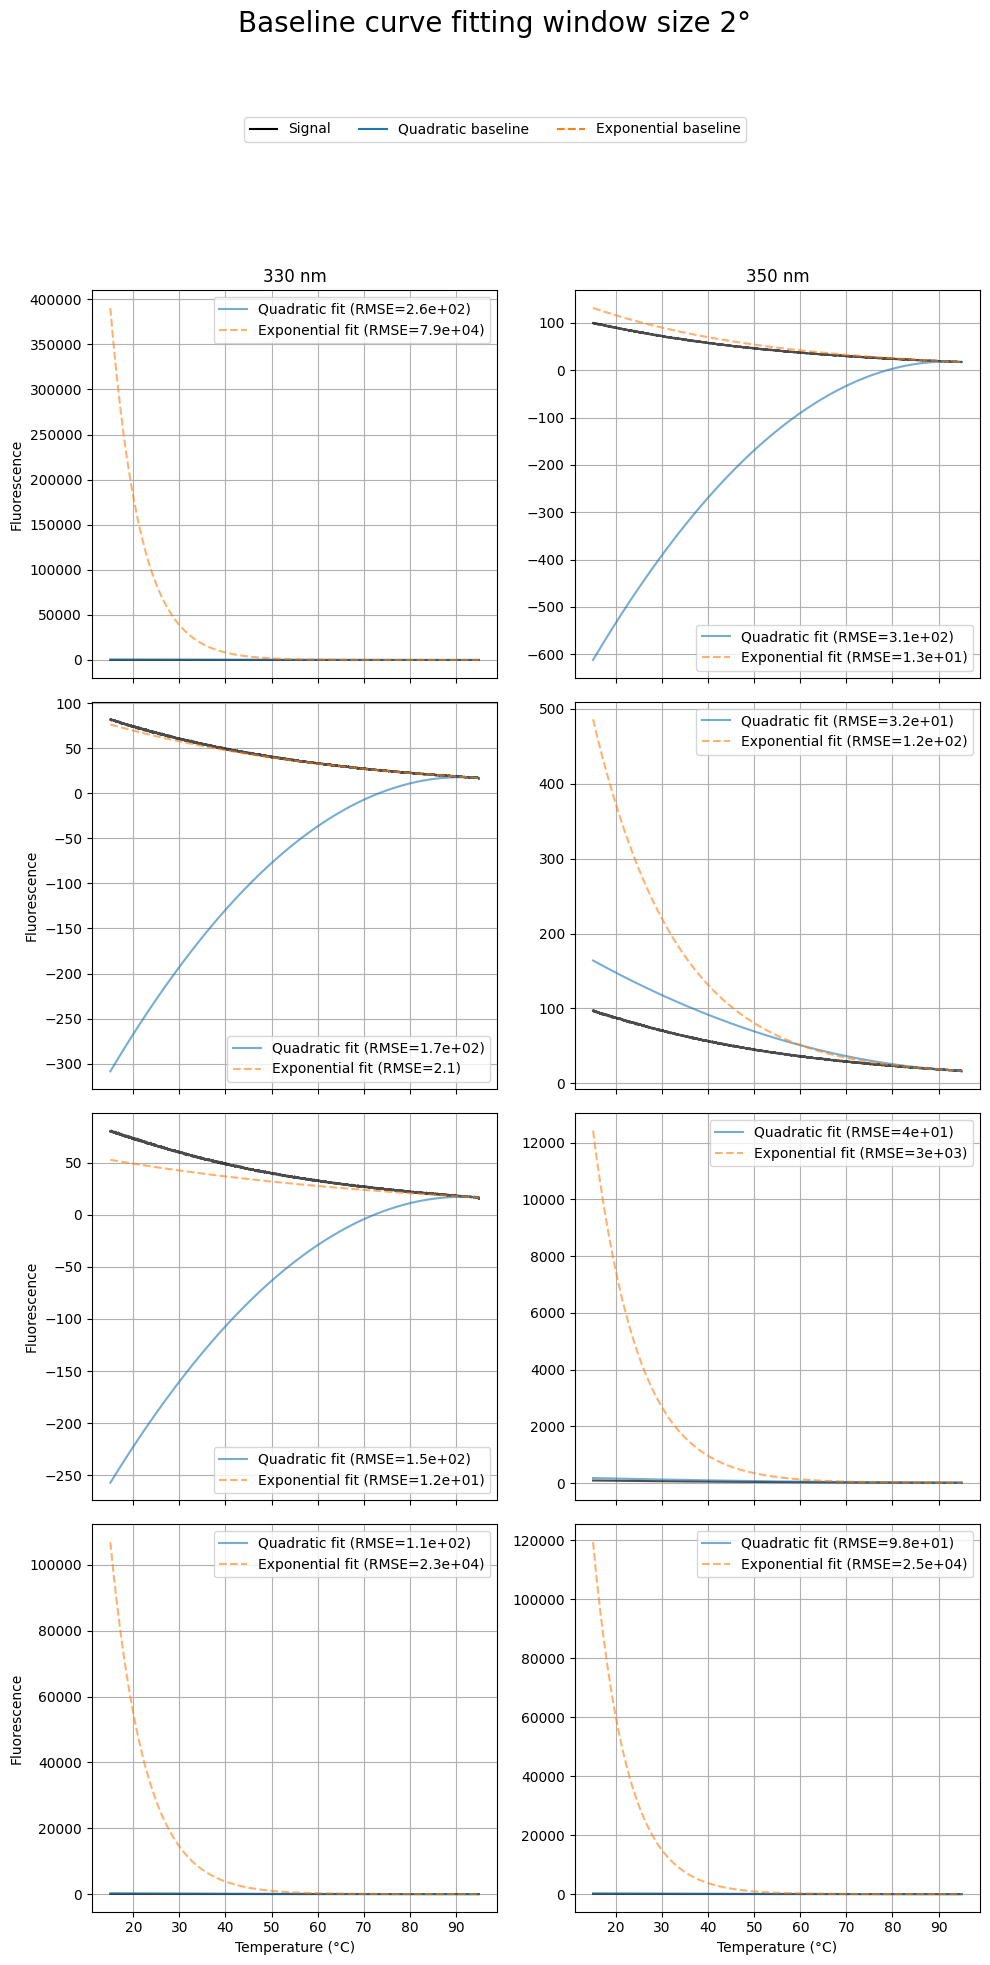

[[[np.float64(255.85140874170148), np.float64(78749.89120828813)],
  [np.float64(171.68134931381005), np.float64(2.0782630095784316)],
  [np.float64(149.45488451803453), np.float64(12.007864464135539)],
  [np.float64(111.41833061652102), np.float64(23153.652448387496)]],
 [[np.float64(313.287602808569), np.float64(12.65219431875716)],
  [np.float64(31.76817105670167), np.float64(121.50137762939845)],
  [np.float64(40.40233637044152), np.float64(3030.237601457285)],
  [np.float64(97.60650806873973), np.float64(25349.924560666925)]]]

In [160]:
#comparing the fits using different window sizes

unfolded_comp(conditions_nf, filename, ws=20)

unfolded_comp(conditions_nf, filename, ws=8)

unfolded_comp(conditions_nf, filename, ws=5)

unfolded_comp(conditions_nf, filename, ws=2)